In [18]:
import matplotlib.pyplot as plt
import pandas as  pd
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

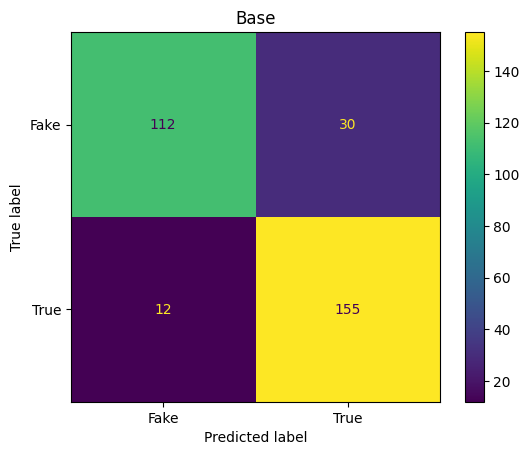

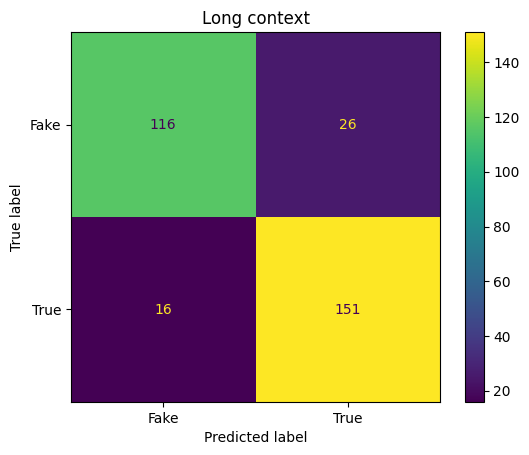

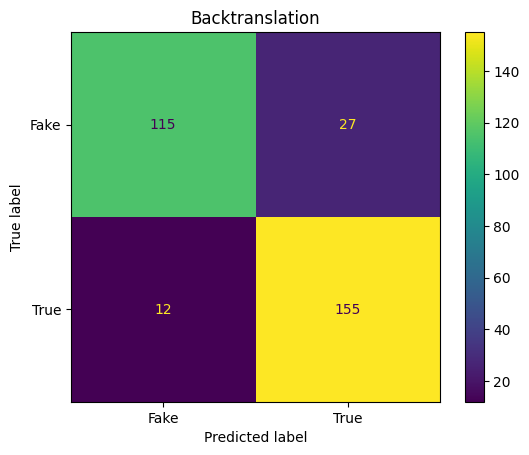

In [19]:
from utils import LABELS
base = pd.read_json('data/predictions/base.json')
#ner = pd.read_json('data/predictions/ner_mask.json')
#noise = pd.read_json('data/predictions/noise.json')
full_length = pd.read_json('data/predictions/full_length.json')
final = pd.read_json('data/predictions/final.json')

models = [base, full_length, final]
nombres = ['Base', 'Long context', 'Backtranslation']

def get_confusion_matrix(df, name):
    cm = confusion_matrix(df['category'], df['predictions'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=LABELS.keys())
    disp.plot()
    plt.title(name)
    plt.show()

for model, nombre in zip(models, nombres):
    get_confusion_matrix(model, nombre)

## Acierto

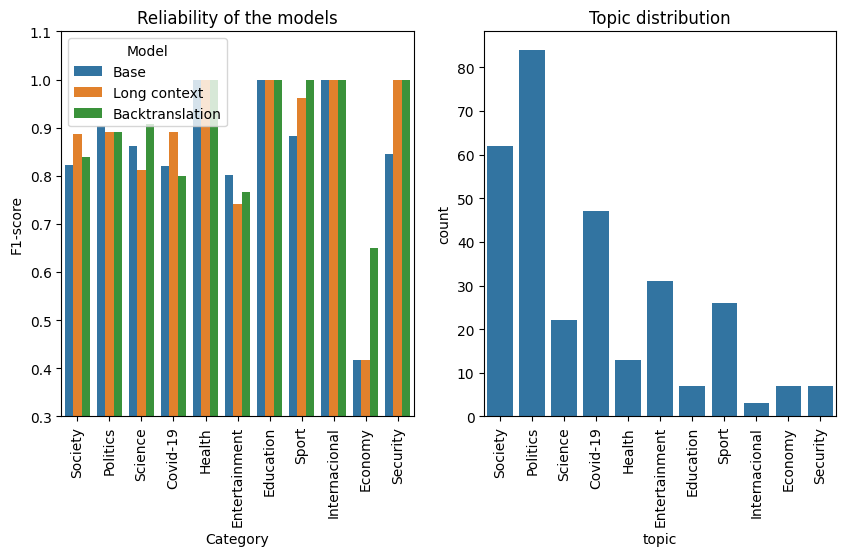

In [15]:
import seaborn as sns
from utils import LABELS

def get_report(data):
    report = {}
    for topic in data['topic'].unique():
        subset = data[data['topic'] == topic]
        report[topic] = classification_report(subset['category'].apply(lambda x: LABELS[x]), 
                                              subset['predictions'].apply(lambda x: LABELS[x]),
                                    labels=np.arange(2).tolist(),
                                    target_names=['Fake','True'],
                                    digits=4,
                                    zero_division=0,
                                    output_dict=True)
    return report

models = [base,full_length,final]

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
reports = [get_report(model) for model in models]
f1 = [[report[topic]['macro avg']['f1-score'] for topic in report.keys()] for report in reports]

nombres = ['Base']*len(f1[0]) + ['Long context']*len(f1[1]) + ['Backtranslation']*len(f1[2])

data = pd.DataFrame({'Category': list(reports[0].keys())*len(reports),
                     'F1-score': [score for sublist in f1 for score in sublist],
                     'Model': nombres})
sns.barplot(x='Category', y='F1-score', hue='Model', data=data)
plt.xticks(rotation=90)
plt.title('Reliability of the models')
plt.ylim(0.3,1.1)

plt.subplot(1,2,2)
sns.countplot(x='topic',  data=full_length)
plt.xticks(rotation=90)
plt.title('Topic distribution')
plt.show()

## Confianza

In [16]:
from matplotlib.gridspec import GridSpec

get_confidence = lambda pred: np.sqrt(np.mean(np.square(pred - 0.5)))

def get_confidence_report(data, title):
    fig = plt.figure(figsize=(10,5))
    gs = GridSpec(2, 4, figure=fig)
    cm = np.zeros((2,2))

    fig.add_subplot(gs[0,0])
    subset = data[(data['category'] == 'Fake') & (data['predictions'] == 'Fake')]
    aux = get_confidence(np.array(subset['prob_fake']))
    cm[0,0] = aux
    sns.histplot(subset['prob_fake'], bins=20, kde=True, stat='percent')
    plt.xlabel('Prob of Fake')
    plt.title('Fake - Fake')

    fig.add_subplot(gs[0,1])
    subset = data[(data['category'] == 'Fake') & (data['predictions'] == 'True')]
    cm[0,1] = get_confidence(np.array(subset['prob_fake']))
    sns.histplot(subset['prob_fake'], bins=10, kde=True, stat='percent')
    plt.xlabel('Prob of Fake')
    plt.title('Fake - True')

    fig.add_subplot(gs[1,0])
    subset = data[(data['category'] == 'True') & (data['predictions'] == 'Fake')]
    cm[1,0] = get_confidence(np.array(subset['prob_fake']))
    sns.histplot(subset['prob_fake'], bins=5, kde=True, stat='percent')
    plt.xlabel('Prob of Fake')
    plt.title('True - Fake')

    fig.add_subplot(gs[1,1])
    subset = data[(data['category'] == 'True') & (data['predictions'] == 'True')]
    cm[1,1] = get_confidence(np.array(subset['prob_fake']))
    sns.histplot(subset['prob_fake'], bins=20, kde=True, stat='percent')
    plt.xlabel('Prob of Fake')
    plt.title('True - True')

    big_ax = fig.add_subplot(gs[:,2:])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=LABELS.keys())
    disp.plot(ax=big_ax, colorbar=False)
    im = big_ax.imshow(cm, interpolation='nearest', cmap='viridis', vmin=0.20, vmax=0.5)
    big_ax.figure.colorbar(im, ax=big_ax)
    plt.title('Mean confidence')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


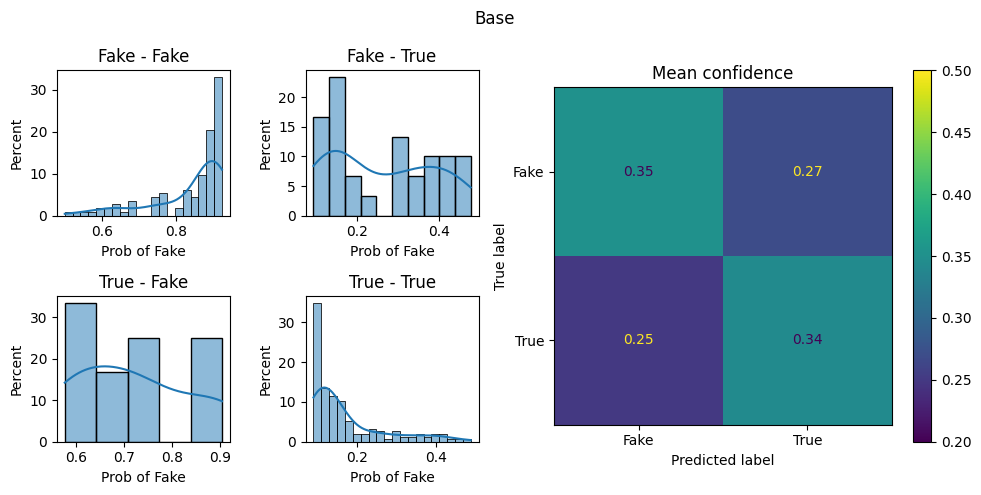

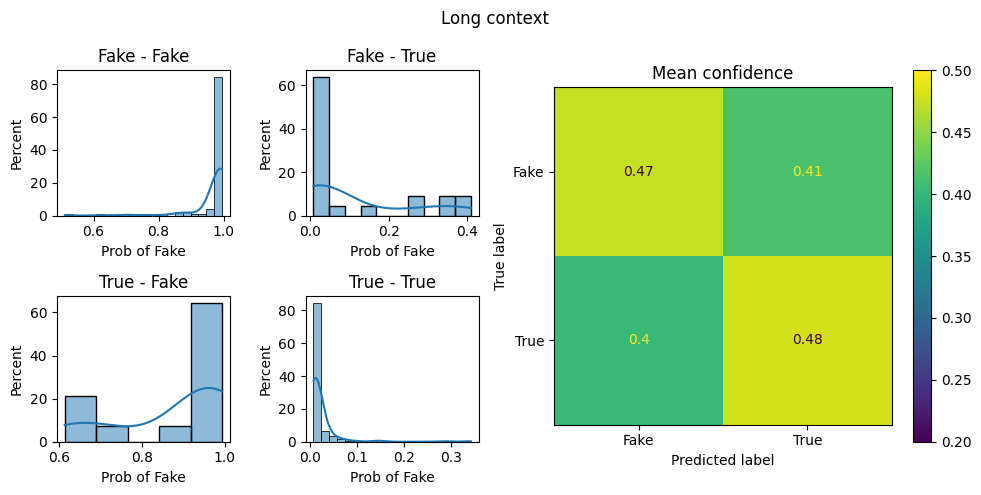

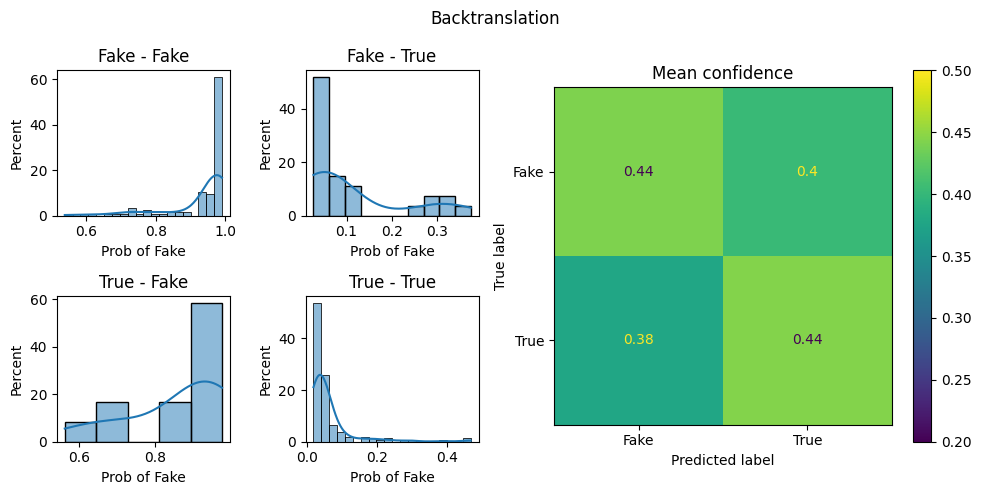

In [17]:
get_confidence_report(base, 'Base')
#get_confidence_report(ner, 'NER-Mask')
#get_confidence_report(noise, 'Noisy embeddings')
get_confidence_report(full_length, 'Long context')
get_confidence_report(final, 'Backtranslation')